# `ModelForge`
### Amortise your Forwards Models

This example is deigned to give a quick overview of how to use `ModelForge` to amortise a forward model.

The main classes we will use are `MLPAmortisedModel`, and `SupervisedAmortiser`

We will use a slightly more complex example, showing how to jointly amortise the recovery of both stellar position (via tip-tilt) and stellar flux. 

As an example we will use the simplest MLP model, with a depth of zero, plus the `ModelForge` `SimpleLinear` layer used as a learning rate filter!

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

# Model Forge
import ModelForge as forge

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

In [2]:
import itertools


# NOTE: Ive kept this in the notebook because its not quite robust enough yet
def build_hyper_trainer(joint_model, **kwargs):
    """This is just a co-pilot clever way to automate hyper param creation, lr must be
    supplied. All inputs must be iterables. Not lr will always appear as a hyper
    parameter."""
    fmodel = joint_model.fmodel
    params = joint_model.params

    # Ensure there is a lr
    if "lr" not in kwargs.keys():
        raise ValueError("lr must be supplied")

    if "init_scale" in kwargs.keys():
        init_scale = kwargs.pop("init_scale")
    else:
        init_scale = 1.0

    # Ensure we know what all the hyper parameters are
    for key in kwargs.keys():
        if key not in ["lr", "depth", "width", "init_scale"]:
        # if key not in ["lr", "depth", "width"]:
            raise ValueError(f"Unknown hyper parameter {key}")

    # Iterate over all combinations of hyper parameters
    keys, values = list(kwargs.keys()), list(kwargs.values())

    optimisers, optims, hypers = [], [], []
    for combination in itertools.product(*values):
        # Build hyper parameters into a dict
        hyperparams = dict(zip(keys, combination))

        # Save values to list
        hypers.append(hyperparams)

        # Built the optimiser's-optimiser
        optims.append(optax.adam(hyperparams["lr"]))

        # Build the optimiser
        # Manually feed in the hyper parameters, because dict.pop removes value even
        # after its been passed into the hypers list... Fuck mutability
        optimisers.append(
            forge.MLPAmortisedModel(
                fmodel,
                params,
                depth=hyperparams["depth"],
                width=hyperparams["width"],
                init_scale=init_scale,
            ).optimiser
        )

    # Return the trainer
    return forge.HyperTrainer(joint_model, optimisers, optims, hypers)

## Make The Forwards Model

In [3]:
import dLuxToliman as dlt

osys = dlt.TolimanOptics(psf_npixels=128, oversample=1)
aperture = dll.Optic(transmission=osys.aperture.transmission, opd=osys.pupil.opd, normalise=True)

In [4]:
# Source parameters
wavelengths = 1e-9 * np.linspace(530, 640, 5)
# source = dl.PointSource(wavelengths, flux=1e4)
source = dl.PointSource(wavelengths, flux=1e6)

# Wavefront parameters
wf_npix = 256
aper_diam = 0.125

# # Generate an aperture manually
# coords = dlu.pixel_coords(5 * wf_npix, 2.4)
# spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
# outer = dlu.circle(coords, aper_diam / 2)
# inner = dlu.circle(coords, 0.3, True)
# spiders = dlu.spider(coords, 0.05, spider_angles)
# aperture = dlu.combine([outer, inner, spiders], 5)

# Generate zernike aberrations
coords = dlu.pixel_coords(wf_npix, aper_diam)
zernikes = np.arange(2, 10)
# zernikes = np.arange(2, 4)
# zernikes = [2, 3, 7, 8, 9, 10]
# basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
basis = np.array([dlu.zernike(i, coords, aper_diam) for i in zernikes])
rms = np.sqrt(np.square(basis).mean((-1, -2)))
basis /= 1e9 * rms[:, None, None] # Normalise to 1nm RMS
coeffs = jr.normal(jr.PRNGKey(0), (len(zernikes),))
aberrations = dll.BasisOptic(transmission=None, basis=basis, coefficients=coeffs)

# PSF parameters
psf_npix = 128
psf_oversample = 2
psf_pix_scale = 0.375 # arcsec/pix

# Construct optics & Telescope
layers = [("aperture", aperture), ("aberrations", aberrations)]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_npix, psf_pix_scale / psf_oversample
)
fmodel = dl.Telescope(optics, source)

## Examine

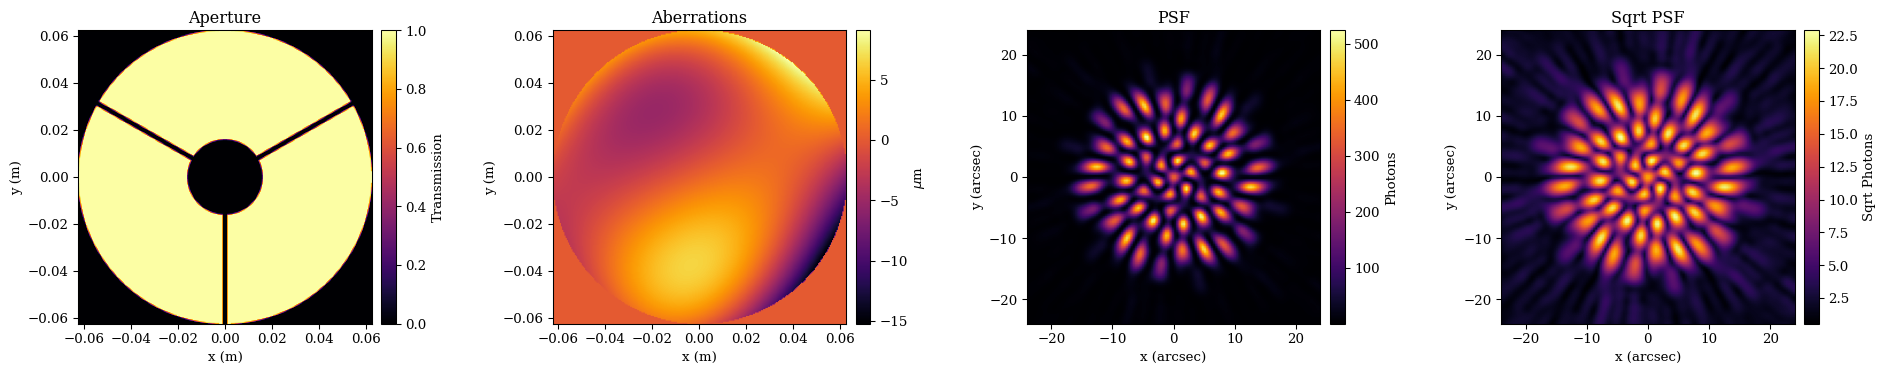

In [5]:
from ModelForge import plotting as p

fig, axes = forge.plot_grid_2d(1, 4)

# Aperture plots
r = aper_diam / 2
extent = (-r, r, -r, r)

axes[0].set(xlabel="x (m)", ylabel="y (m)", title="Aperture")
im = axes[0].imshow(optics.transmission, extent=extent)
forge.add_cbar(fig, axes[0], im, label="Transmission")

axes[1].set(xlabel="x (m)", ylabel="y (m)", title="Aberrations")
im = axes[1].imshow(1e9 * optics.eval_basis(), extent=extent)
forge.add_cbar(fig, axes[1], im, label="$\mu$m")

# PSF plots
psf = fmodel.model()
r = psf_pix_scale * psf_npix / 2
extent = (-r, r, -r, r)

axes[2].set(xlabel="x (arcsec)", ylabel="y (arcsec)", title="PSF")
im = axes[2].imshow(psf, extent=extent)
forge.add_cbar(fig, axes[2], im, label="Photons")

axes[3].set(xlabel="x (arcsec)", ylabel="y (arcsec)", title="Sqrt PSF")
im = axes[3].imshow(psf**0.5, extent=extent)
forge.add_cbar(fig, axes[3], im, label="Sqrt Photons")
fig.tight_layout()

# Generate Samples

Two options here, a single parameter and multiple parameters, just to show that they both work

In [6]:
# Example one: A single parameter
params = ["coefficients"]
# init_scale = 5e-1
init_scale = 1e-1
joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=init_scale)

# # Generate training and testing distributions
# truth_prior = [forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape)]
# train_prior = [forge.Normal(mu=0, sigma=50, bc_shape=coeffs.shape)]

# NOTE: For Toliman this is a much greater amount of aberration!!
# This is trying to recover an aberrated psf from an unaberrated one
truth_prior = [forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape)]
train_prior = [forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape)]

In [7]:
# # Example 2: Two parameters
# params = ["coefficients", "flux"]
# # joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=1e-1)
# fmodel = fmodel.set('flux', np.array([1e4]))
# print(fmodel.flux.shape)
# print(fmodel.coefficients.shape)
# joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=2e0)

# # Generate training and testing distributions
# truth_prior = [
#     forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape),
#     forge.Normal(mu=1e4, sigma=100)
# ]
# train_prior = [
#     forge.Normal(mu=0, sigma=50, bc_shape=coeffs.shape),
#     forge.Normal(mu=1e4, sigma=100)
# ]

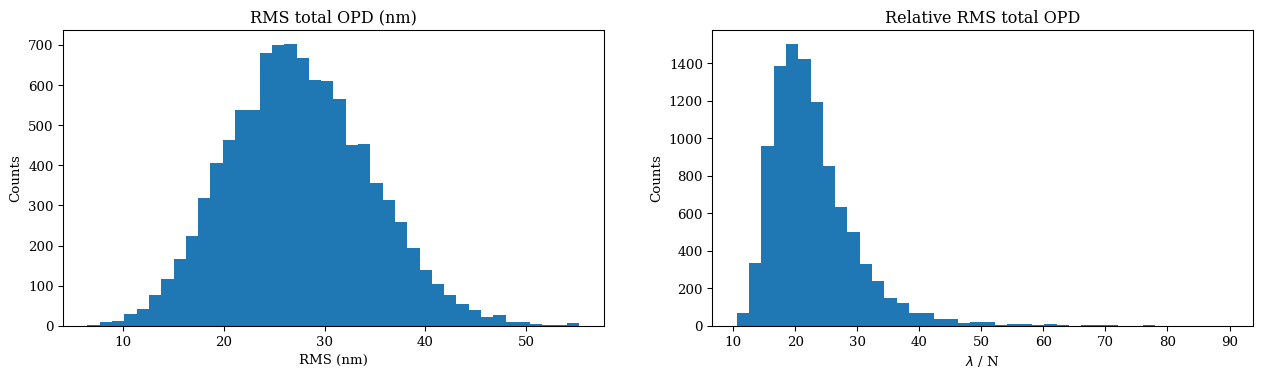

In [8]:

rms_nm = lambda x: np.sqrt(np.square(x).mean((-1, -2))) * 1e9
eval_aber = lambda x: joint_model.fmodel.set(joint_model.params, x).eval_basis()
get_rms = lambda x: rms_nm(eval_aber(x))

true, key = forge.sample(truth_prior, 10000, jr.PRNGKey(0))
rms_vals = jax.vmap(get_rms)(true[0])
mean_wavel = wavelengths.mean() * 1e9
fig, axes = forge.plot_grid_2d(1, 2, fsx=8)
axes[0].hist(rms_vals, bins=40)
axes[0].set(title="RMS total OPD (nm)", xlabel="RMS (nm)", ylabel="Counts")

axes[1].hist(mean_wavel / rms_vals, bins=40)
axes[1].set(title="Relative RMS total OPD", xlabel="$\lambda$ / N", ylabel="Counts");

## Examine the initialisation performance

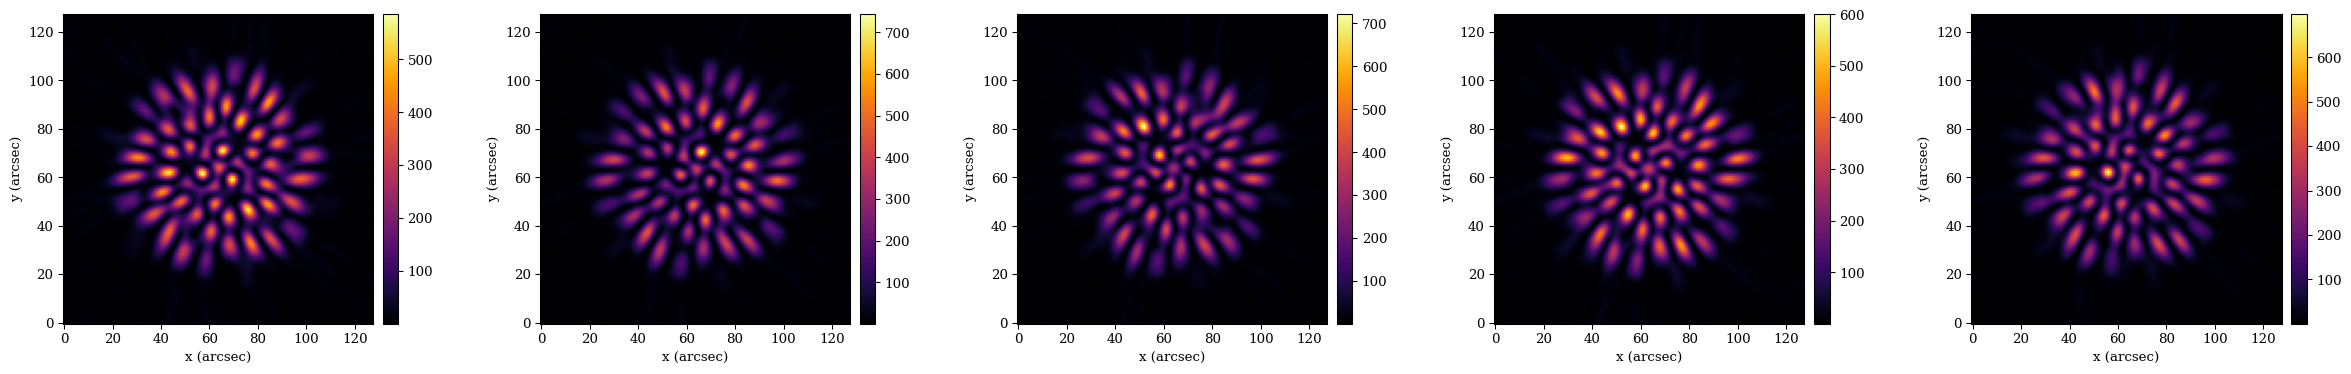

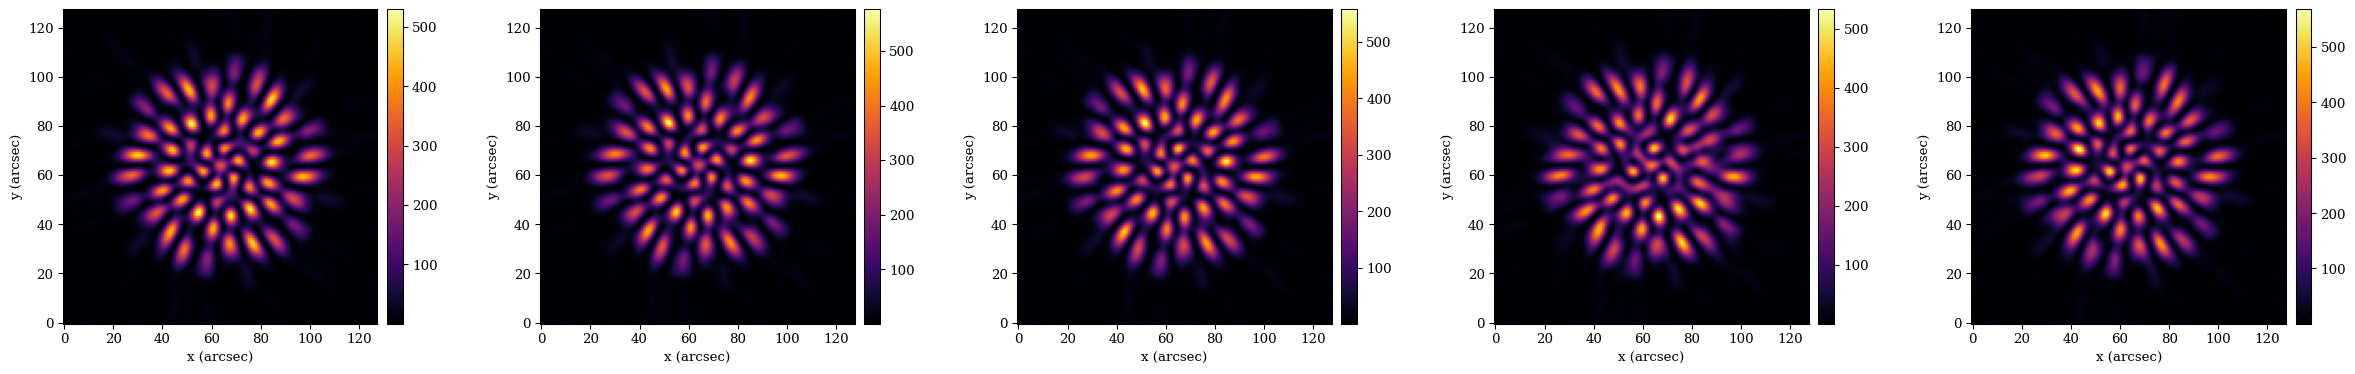

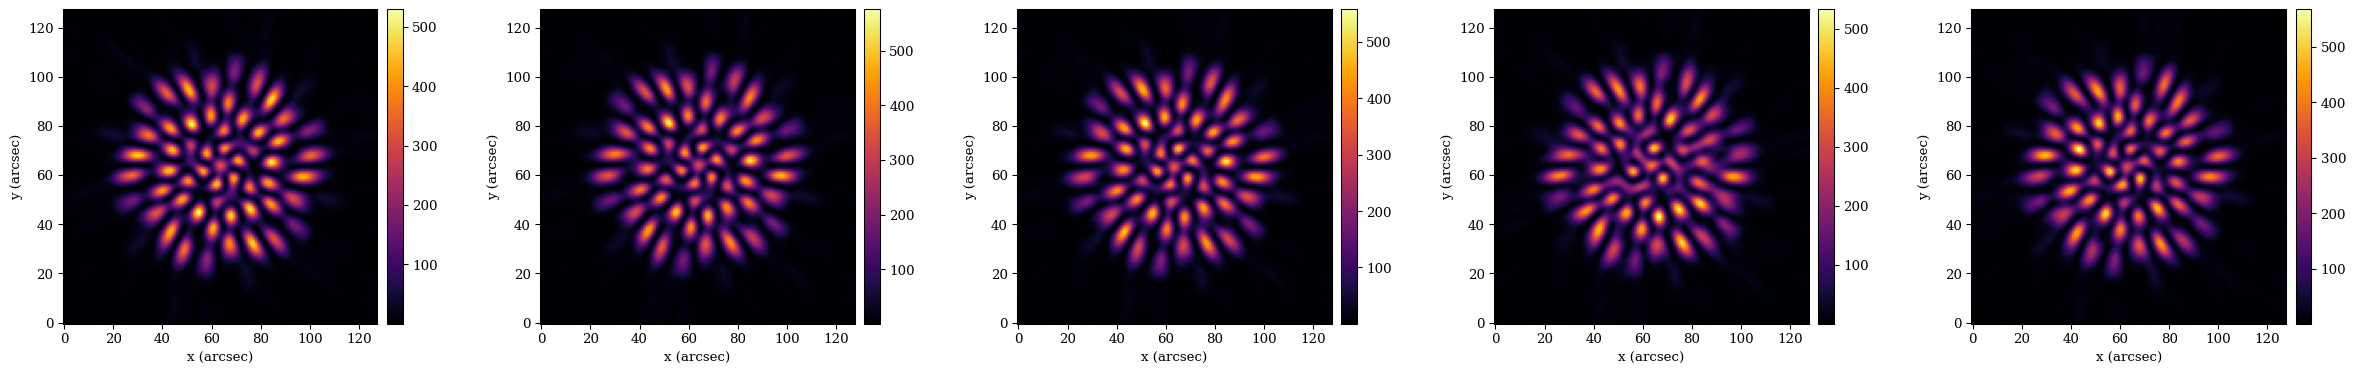

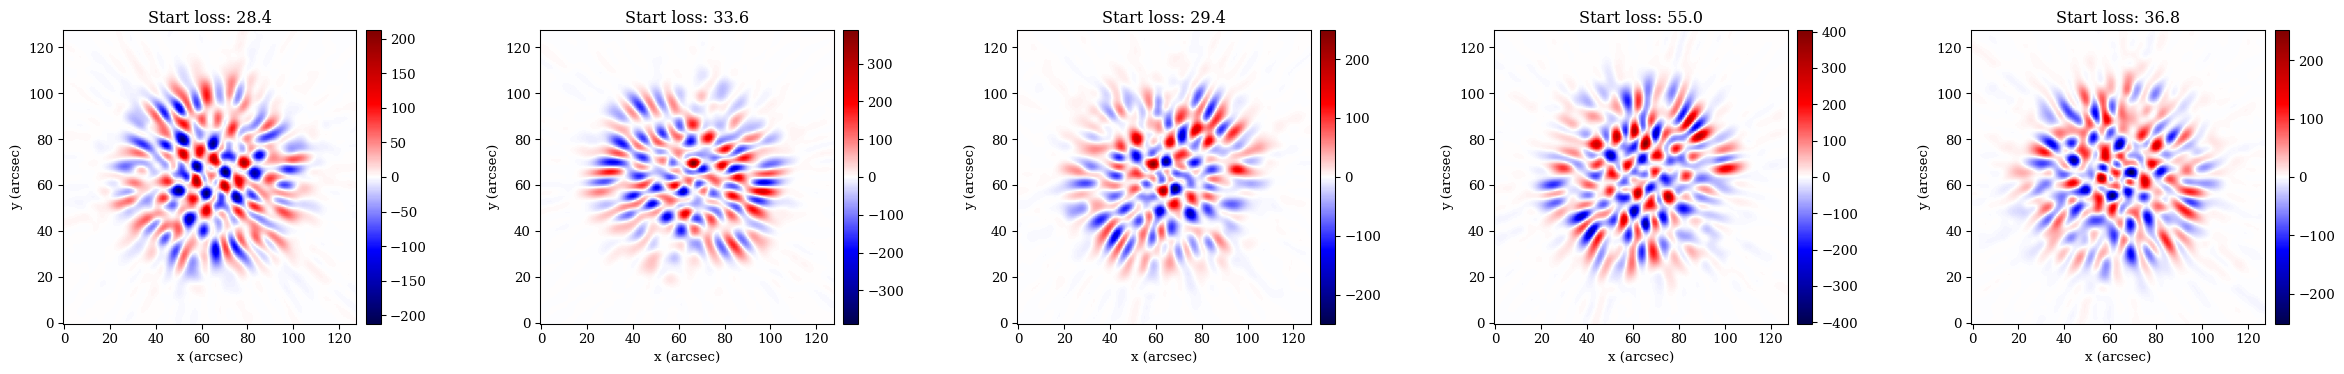

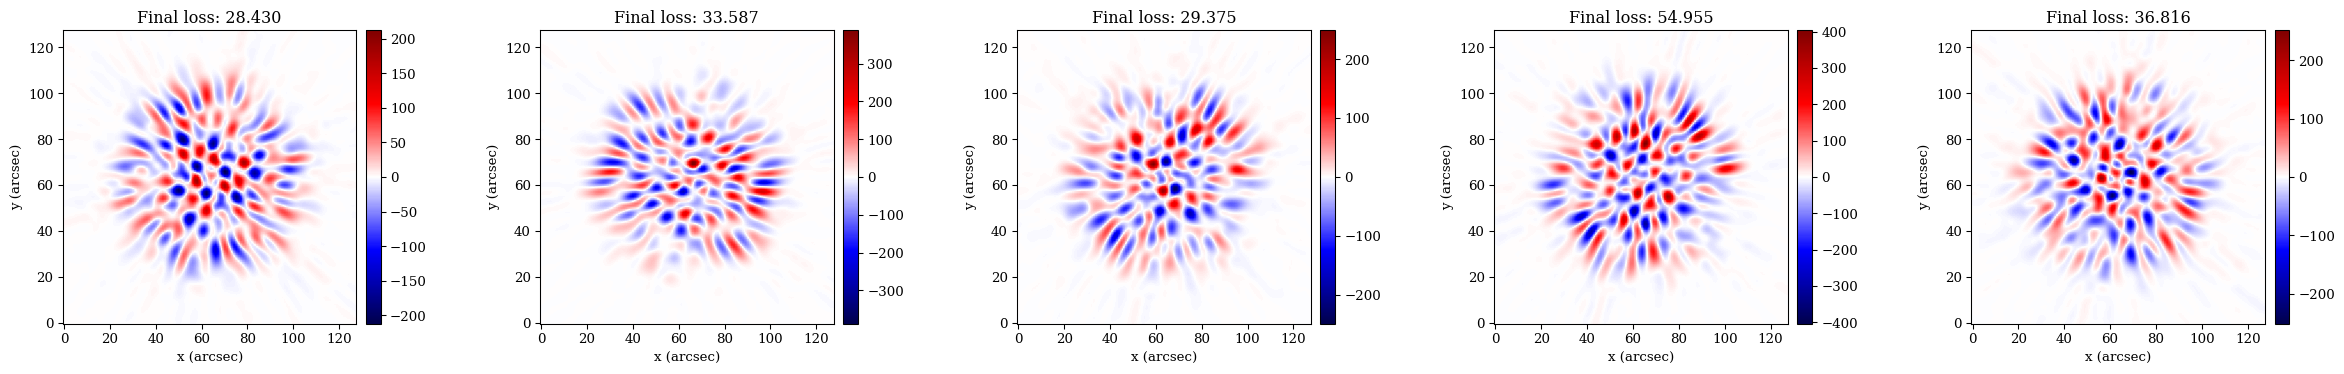

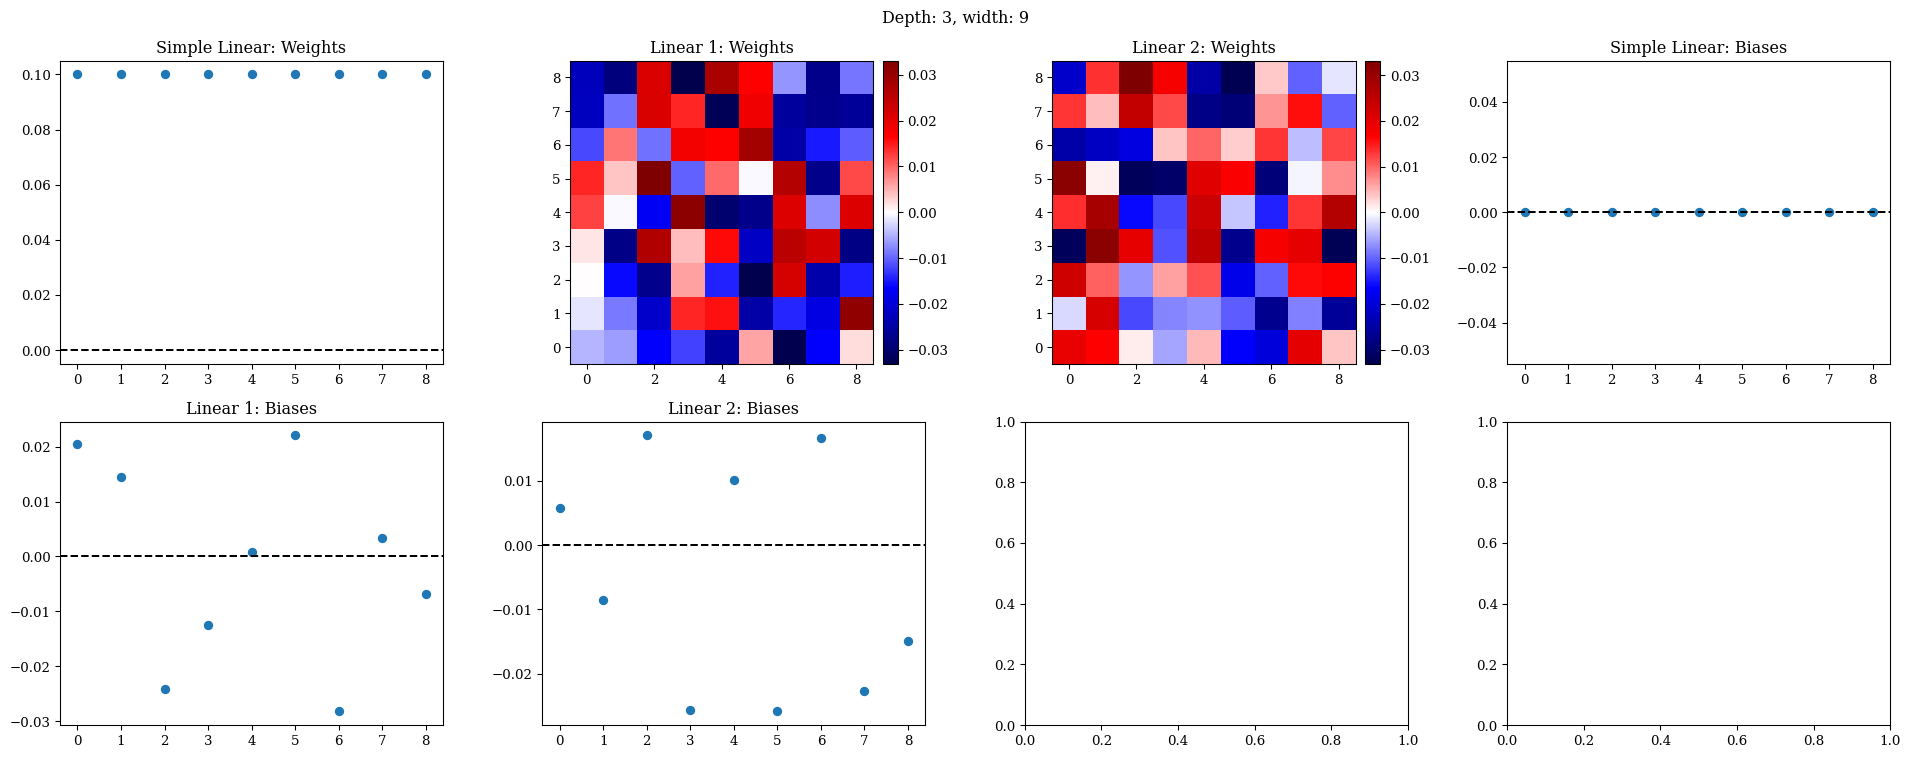

In [9]:
r, c = 1, 5
true, key = forge.sample(truth_prior, r * c, jr.PRNGKey(0))
train, key = forge.sample(train_prior, r * c, key)

# Get target and sample psfs
target_psfs = joint_model.model_samples(true)
sample_psfs = joint_model.model_samples(train)

# Get predicted psfs
predicted = eqx.filter_vmap(joint_model.predict)(train, target_psfs)
predicted_psfs = joint_model.model_samples(predicted)

p = 1

# Plot truth - sample points
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(target_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot truth - predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(sample_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot truth - predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(predicted_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# We can examine the initialisation conditions here if we want
forge.examine_predictions(joint_model, truth_prior, train_prior, 1, 5)
forge.visualise_optimiser(joint_model.optimiser)

In [10]:
# NOTE! Compile times scale linearly with the number of hyper parameters, however this
# typically has no effect on runtime performance because the expensive part of the
# training is the calculation of forwards model gradients which is done once and then
# passed to all the optimisers in parallel. This allows us to perform a very large
# hyper parameter, with almost zero performance hit per epoch.

# Compile time currently scales linearly with batch size? - test this

# As a rough gauge, compile time seemed to be ~1-2s per hyper parameter combination

# Define hyperparameters and build our hyper-trainer
lrs = 10 ** np.linspace(-2, -1, 3)
depths = [0, 1, 2]
widths = np.linspace(1, 4, 4).astype(float)

# lrs = 10 ** np.linspace(-3, -1, 1)
# depths = [0, 1]
# widths = np.linspace(1, 4, 1).astype(float)

hyper_trainer = build_hyper_trainer(
    joint_model, lr=lrs, depth=depths, width=widths, init_scale=init_scale
)

print(np.log10(lrs))
print(depths)
print(widths)
print(len(depths) * len(widths) * len(lrs))

[-1.9999999  -1.5        -0.99999994]
[0, 1, 2]
[1. 2. 3. 4.]
36


Training 36 Optimisers over 1 steps on 25 PSFs for 500 epochs.
Total forwards model grad evaluations per epoch: 25.
Compiling step function... Done! Took 16.03s


Best:   0%|          | 0/500 [00:00<?, ?it/s]

LR:       0     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1
Depth:    0        0        0        0        0        1        1        1        1        2        2        2        2        0        0        0        0        1        1        1        1        2        2        2        2        0        0        0        0        1        1        1        1        2        2        2        2
Width:    0        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3  

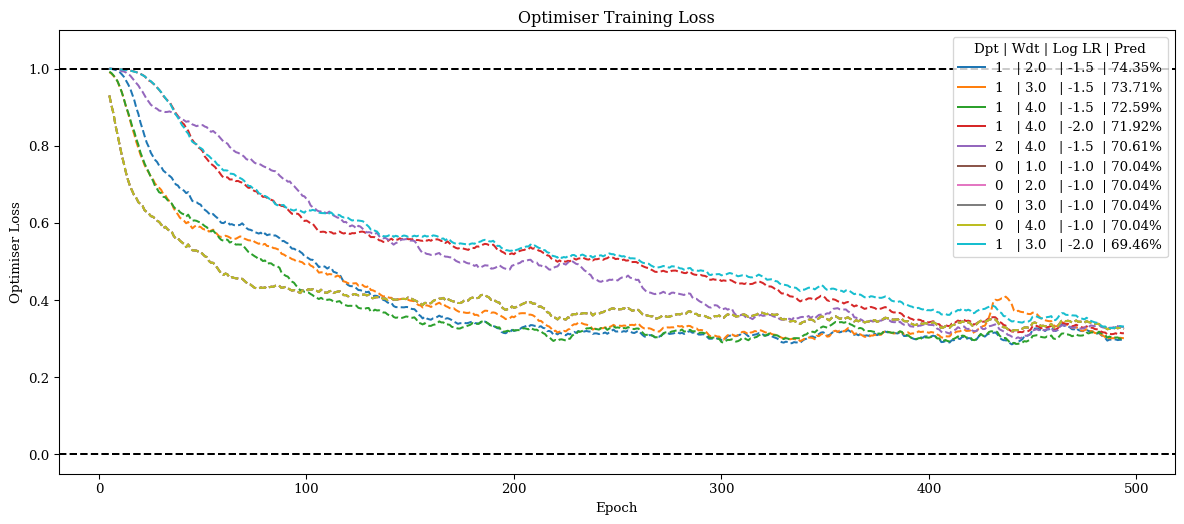

In [11]:
# Train
hyper_trainer, train_key = hyper_trainer.train_stochastic(
    truth_prior, train_prior, epochs=500, batch_size=25, truth_batch_size=25, key=jr.PRNGKey(0),
)

# TODO: Plot histogram of each optimiser performance grouped by hyper parameter
# TODO: class method that returns the mean loss of the last n epochs, and optionally, 
# the index of the best performing optimiser
# TODO: Similar that just returns the indices 
# TODO: Also add a 'get_ith' that returns all the components of the ith optimiser 
# and hyper params. As a dict?


# Plot results
# Note: No legend since we have 99 hyper params
# Note: This can take a long time to run, since it plots all 99 optimisers for all epochs
# TODO: plot histogram of final losses
hyper_trainer.plot_losses(n_top=10, plot_losses=False)

# TODO: print depth and width as (d, w)
# TODO: The hyper-parameters dont line up with the losses.

# Note that the progress -bar displays the best 5 performing optimisers per-epoch

In [12]:
# train_key = jr.PRNGKey(0)

# # This is actually training on 10,000 samples per epoch, not 1000
# for i in range(10):
#     hyper_trainer, train_key = hyper_trainer.train_stochastic(
#         truth_prior, train_prior, epochs=100, batch_size=100, truth_batch_size=100, key=train_key,
#     )
# hyper_trainer.plot_losses(n_top=10, plot_losses=False)

  0%|          | 0/10 [00:00<?, ?it/s]

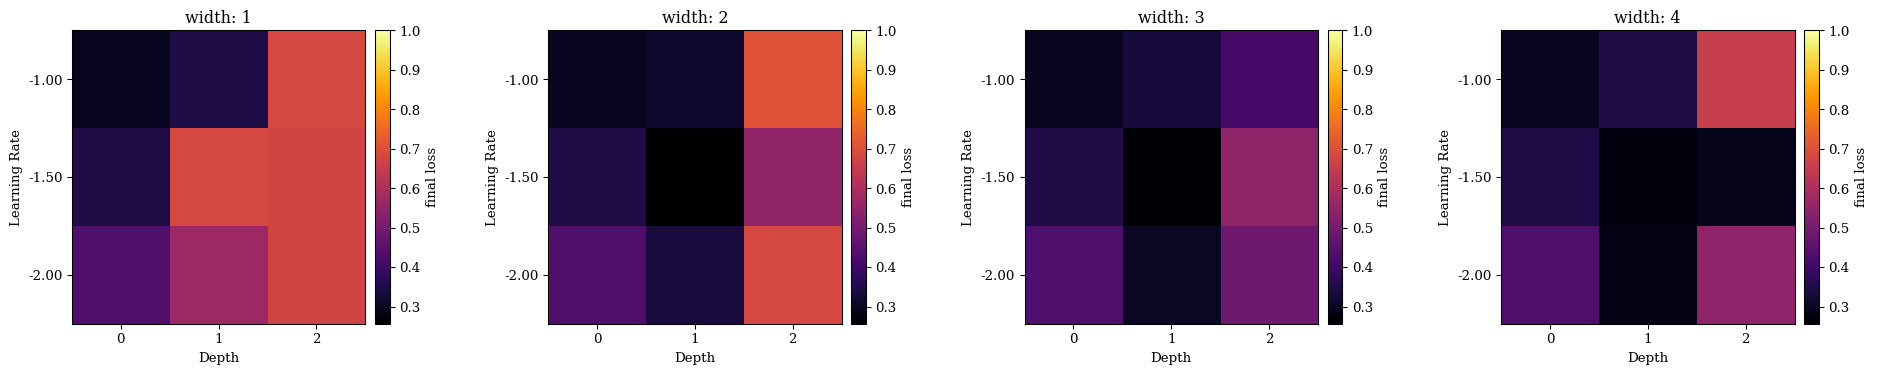

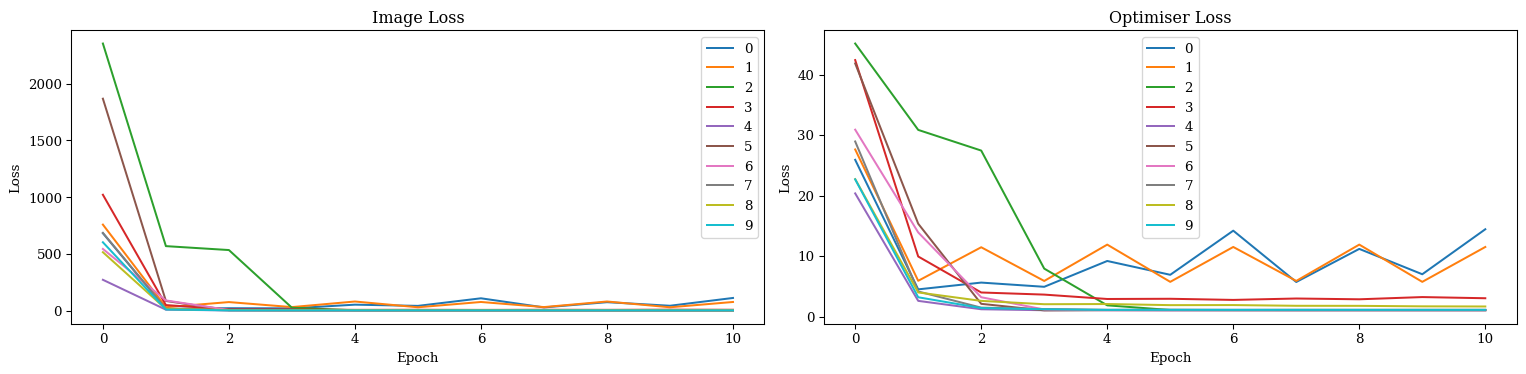

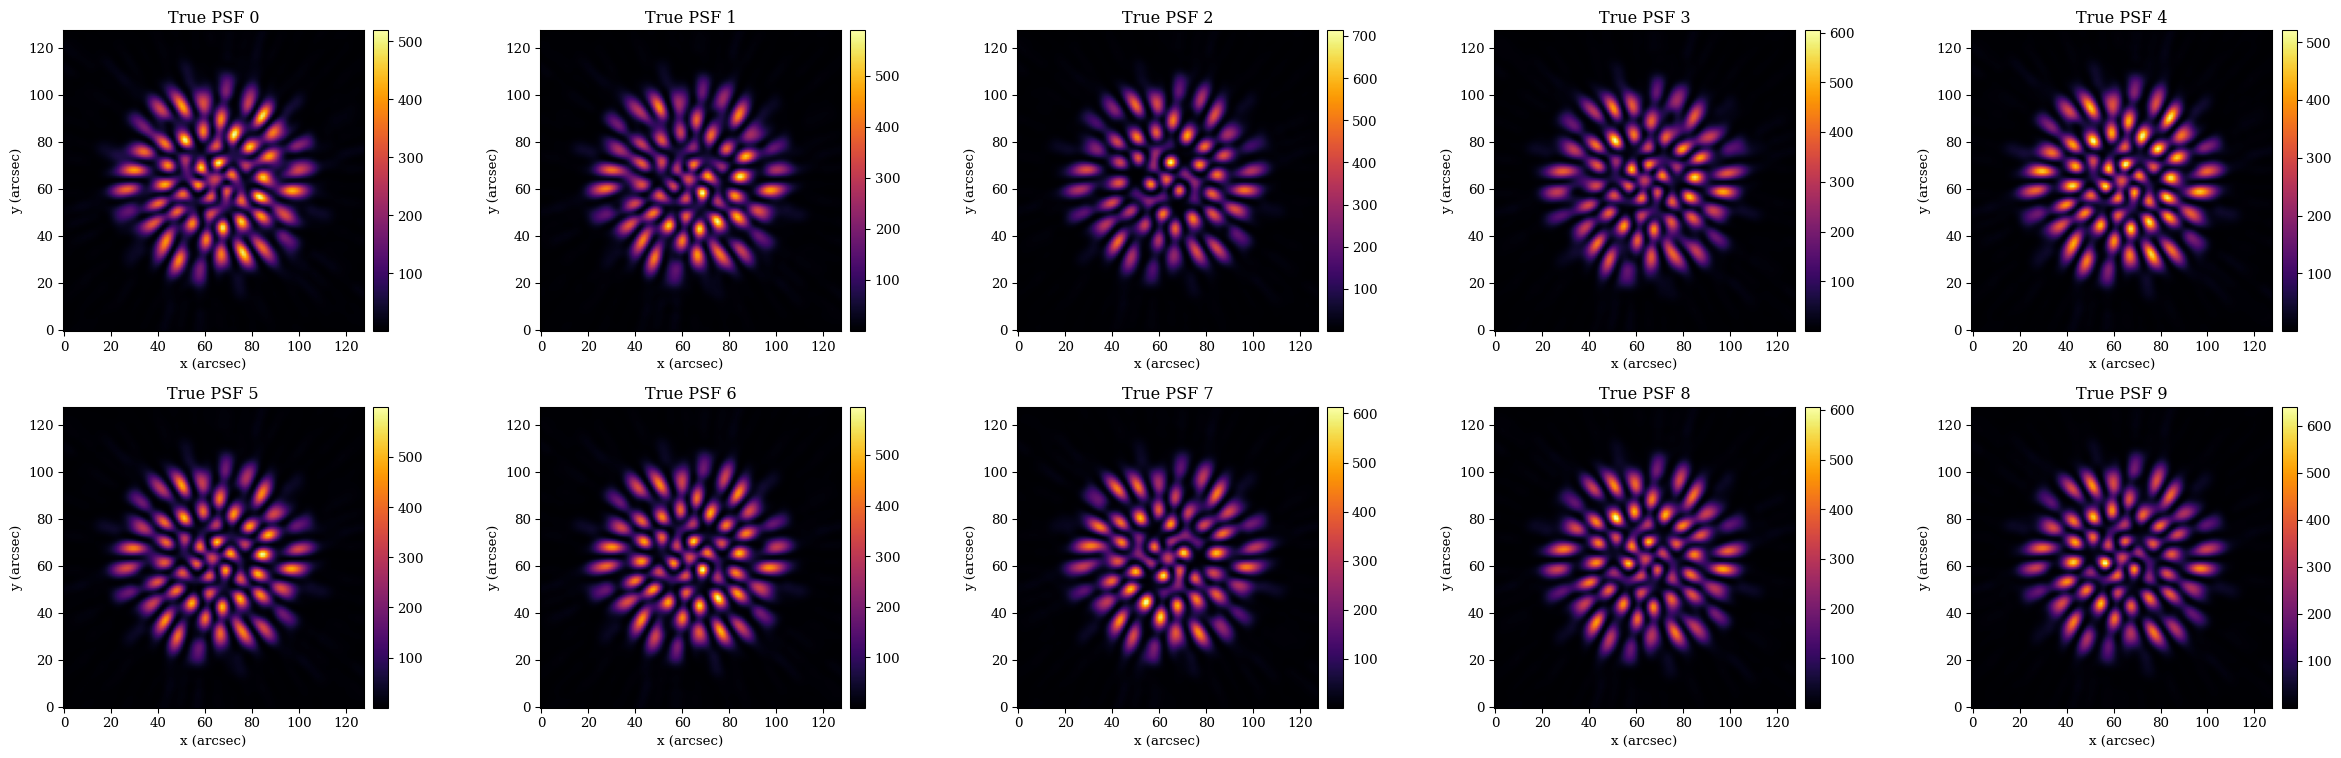

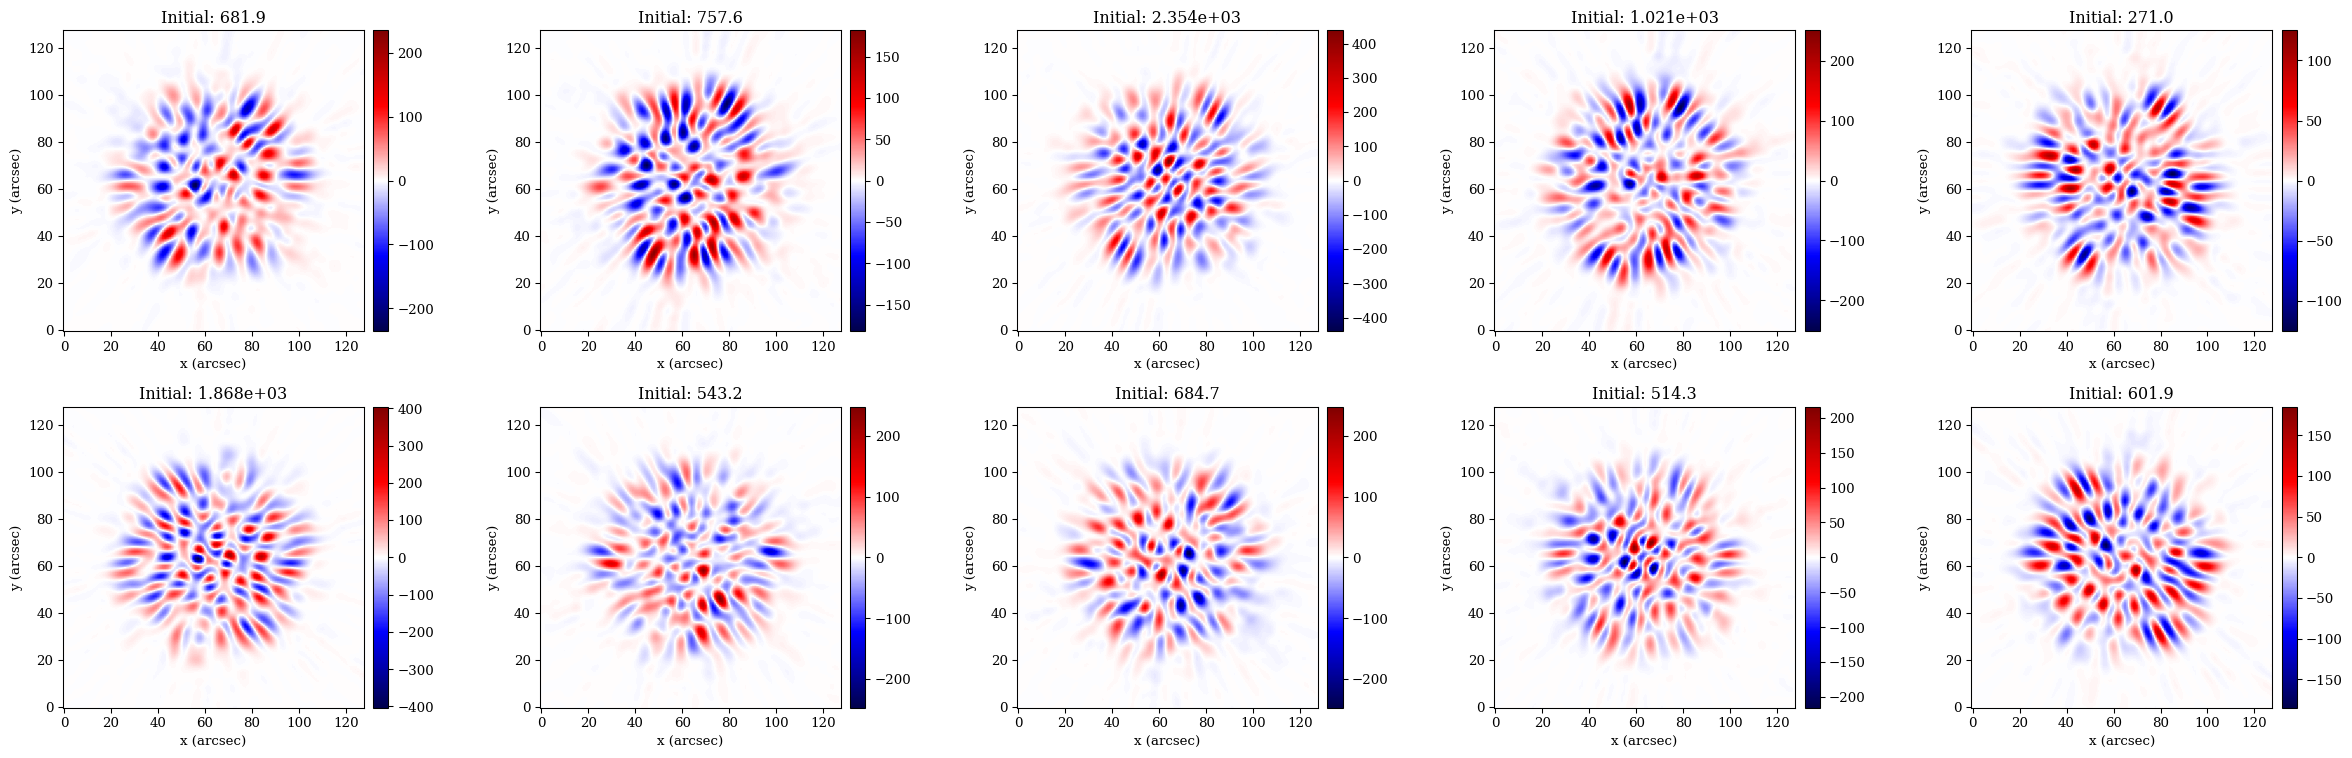

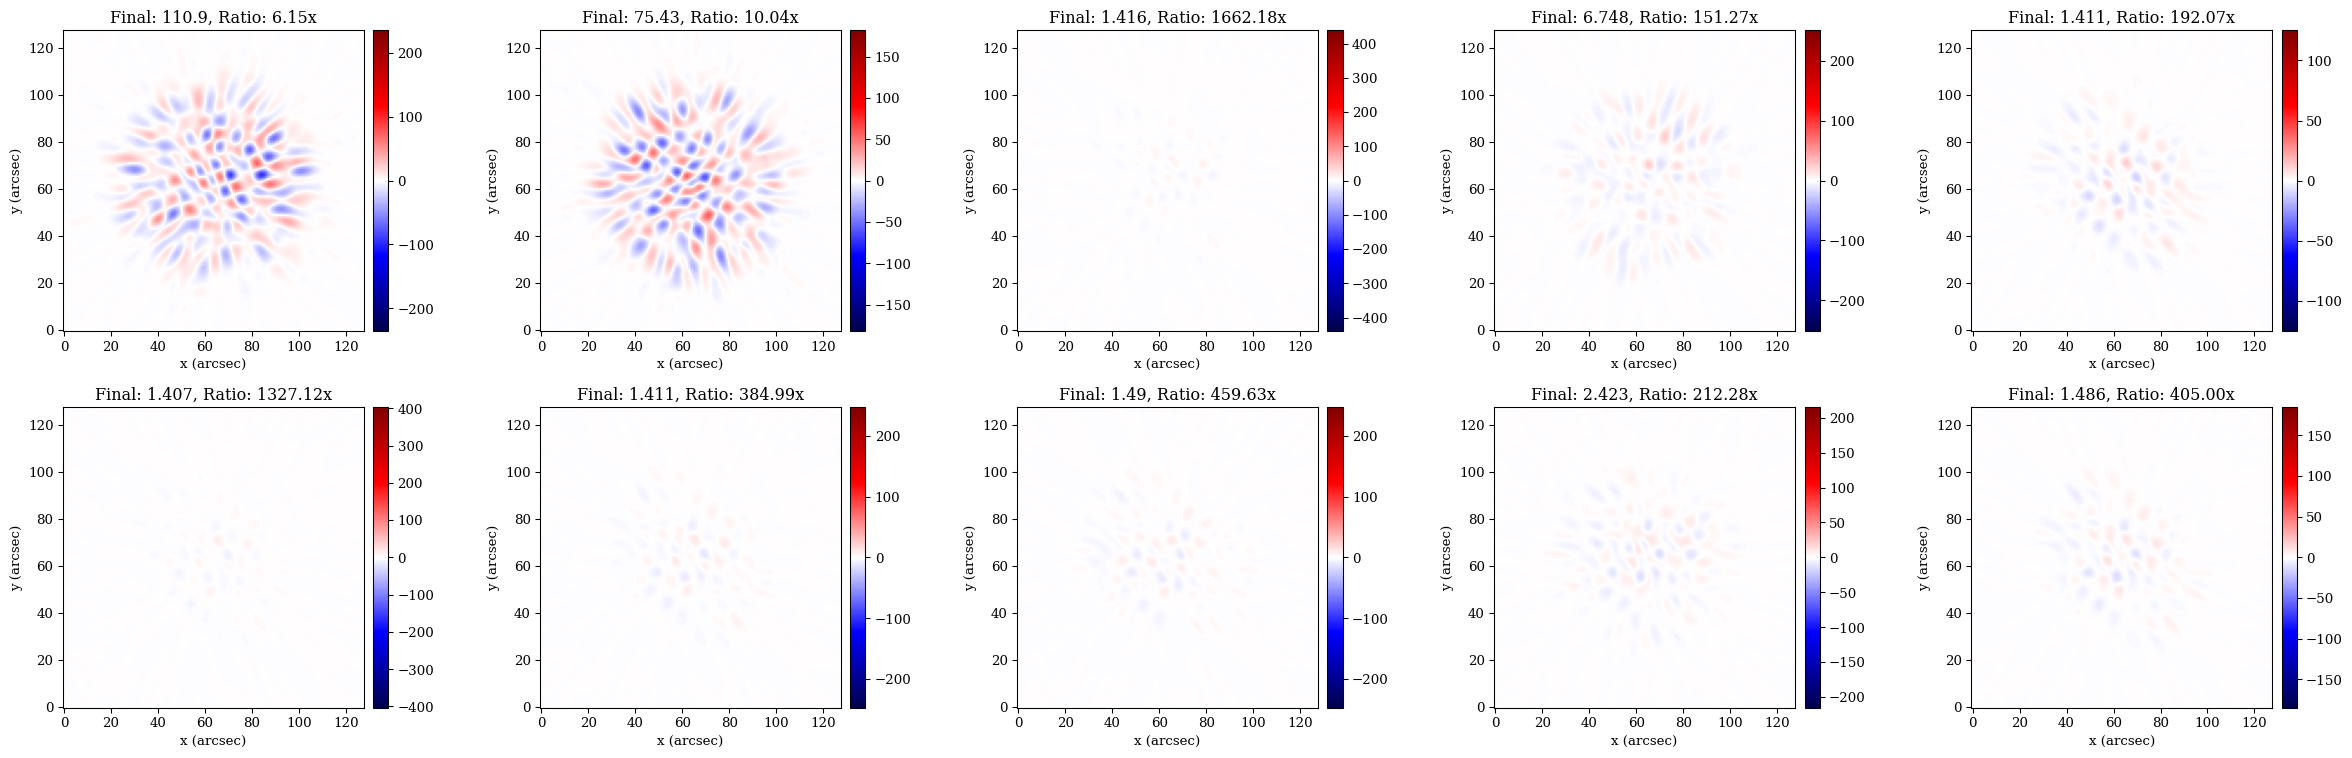

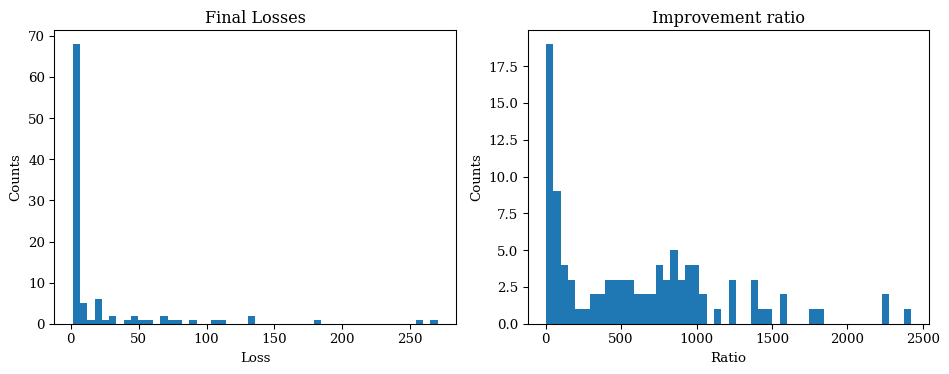

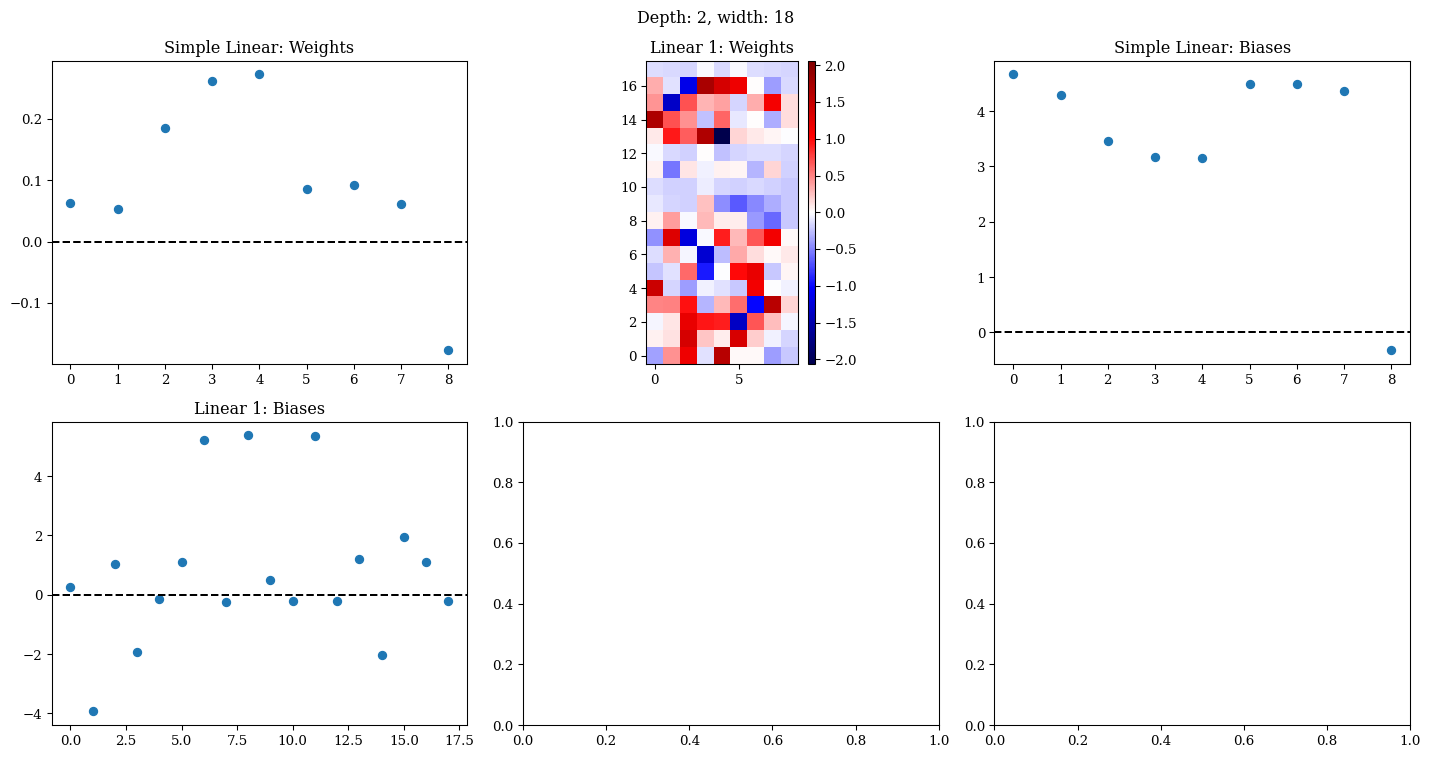

In [17]:
import numpy as onp

means = np.array(hyper_trainer.losses)[:, -1:].mean(1)
inds = np.argsort(means)
best = hyper_trainer.optimisers[inds[0]]
joint_model = eqx.tree_at(lambda tree: tree.optimiser, hyper_trainer.joint_model, best)


# Final loss vs hyper params
hypers_list = hyper_trainer.hypers
for mean, hyp in zip(means, hypers_list):
    hyp["loss"] = float(mean)
    hyp["lr"] = float(hyp["lr"])
    hyp["depth"] = int(hyp["depth"])
    hyp["width"] = int(hyp["width"])
dict_list = hypers_list

# Get a list of unique hyperparameter values
lr_values = sorted(set(d["lr"] for d in dict_list))
depth_values = sorted(set(d["depth"] for d in dict_list))
width_values = sorted(set(d["width"] for d in dict_list))

# Create a 3D array of losses for each combination of hyperparameters
loss_array = onp.zeros((len(lr_values), len(depth_values), len(width_values)))
for i, lr in enumerate(lr_values):
    for j, depth in enumerate(depth_values):
        for k, width in enumerate(width_values):
            for d in dict_list:
                if d["lr"] == lr and d["depth"] == depth and d["width"] == width:
                    loss_array[i, j, k] = d["loss"]


vmin = np.min(loss_array)
fig, axes = forge.plot_grid_2d(1, len(width_values))
for i in range(len(width_values)):
    im = axes[i].imshow(loss_array[:, :, i], vmin=vmin, vmax=1)
    forge.add_cbar(fig, axes[i], im, label="final loss")
    axes[i].set(
        title=f"width: {width_values[i]}",
        xlabel="Depth",
        ylabel="Learning Rate",
        xticks=range(len(depth_values)),
        yticks=range(len(lr_values)),
        xticklabels=depth_values,
        yticklabels=[f"{np.log10(lr):.2f}" for lr in lr_values],
    )
fig.tight_layout()

##################
### Optimising ###
##################


def optimise_fn(joint_model, sample, truth, data, n_opt=5):
    # Bind fns
    update = lambda x: joint_model.fmodel.set(joint_model.params, x)
    im_loss_fn = lambda x: joint_model.image_loss(update(x), data)
    dist_loss_fn = lambda x: np.linalg.norm(x - truth)

    # Optimise
    opt_losses, im_losses = [dist_loss_fn(sample)], [im_loss_fn(sample)]
    for i in range(n_opt):
        sample = joint_model.predict(sample, data)[0]
        fmodel = joint_model.fmodel.set(joint_model.params, sample)
        im_losses.append(im_loss_fn(sample))
        opt_losses.append(dist_loss_fn(sample))
    return np.array(opt_losses), np.array(im_losses), np.array(sample)


# TODO: Plot prediction loss too - 'training loss' and 'image loss'
rows, cols = 2, 5
n_opt = 10
n_samples = rows * cols
truths, key = forge.sample(truth_prior, n_samples, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

# Optimise
true_psfs = joint_model.model_samples(truths)
final_predictions = []
image_losses = []
optimiser_losses = []
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), true_psfs[j])
    data = true_psfs[j]
    opt_losses, im_losses, final_sample = optimise_fn(
        joint_model, samples[0][j], truths[0][j], data, n_opt
    )
    final_predictions.append(final_sample)
    image_losses.append(im_losses)
    optimiser_losses.append(opt_losses)

fig, axes = forge.plot_grid_2d(1, 2, fsx=8)
for i in range(n_samples):
    axes[0].plot(image_losses[i], label=i)
    axes[1].plot(optimiser_losses[i], label=i)
axes[0].set(xlabel="Epoch", ylabel="Loss", title=f"Image Loss")
axes[1].set(xlabel="Epoch", ylabel="Loss", title=f"Optimiser Loss")
axes[0].legend()
axes[1].legend()
fig.tight_layout()

##################
### Visualising ##
##################

# Get initial and predicted psfs
sample_psfs = joint_model.model_samples(samples)
predicted_psfs = joint_model.model_samples(np.array(final_predictions))

# Get residuals
initial_residuals = np.array(true_psfs) - np.array(sample_psfs)
final_residuals = np.array(true_psfs) - np.array(predicted_psfs)
residuals = np.array([initial_residuals, final_residuals])
vs = np.abs(residuals).max((0, -1, -2))

# Plot truth
fig, axes = forge.plot_grid_2d(rows, cols)
for i in range(n_samples):
    im = axes[i].imshow(true_psfs[i])
    axes[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"True PSF {i}",
    )
    forge.add_cbar(fig, axes[i], im)
fig.tight_layout()

# Plot Predicted
fig, axes = forge.plot_grid_2d(rows, cols)
for i in range(n_samples):
    im = axes[i].imshow(initial_residuals[i], vmin=-vs[i], vmax=vs[i], cmap="seismic")
    axes[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Initial: {image_losses[i][0]:.4}",
    )
    forge.add_cbar(fig, axes[i], im)
fig.tight_layout()

# Plot Final Residual
fig, axes = forge.plot_grid_2d(rows, cols)
for i in range(n_samples):
    improvement_ratio = image_losses[i][0] / image_losses[i][-1]
    im = axes[i].imshow(final_residuals[i], vmin=-vs[i], vmax=vs[i], cmap="seismic")
    axes[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Final: {image_losses[i][-1]:.4}, Ratio: {improvement_ratio:.2f}x",
    )
    forge.add_cbar(fig, axes[i], im)
fig.tight_layout()


# Histogram over a large sample
truths, key = forge.sample(truth_prior, 100, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, 100, key)
true_psfs = joint_model.model_samples(truths)
def opt_fn(sample, truth, data):
    opt_losses, im_losses, final_sample = optimise_fn(
        joint_model, sample, truth, data, n_opt=n_opt
    )
    return im_losses[-1], im_losses[0] / im_losses[-1]

final_loss, final_ratio = eqx.filter_vmap(opt_fn)(samples[0], truths[0], true_psfs)
fig, axes = forge.plot_grid_2d(1, 2)
axes[0].hist(final_loss, bins=50)
axes[0].set(title="Final Losses", xlabel="Loss", ylabel="Counts")
axes[1].hist(final_ratio, bins=50)
axes[1].set(title="Improvement ratio", xlabel="Ratio", ylabel="Counts")
fig.tight_layout()

# data = true_psfs[j]
# opt_losses, im_losses, final_sample = optimise_fn(
#     joint_model, samples[0][j], truths[0][j], data
# )
# final_predictions.append(final_sample)
# image_losses.append(im_losses)
# optimiser_losses.append(opt_losses)


# Examine predictions
forge.visualise_optimiser(joint_model.optimiser)

## TODO: Plot histograms of final losses after the small optimisation done above for a large batch size

Sample class?

## Re-Train

Training 36 Optimisers over 1 steps on 25 PSFs for 500 epochs.
Total forwards model grad evaluations per epoch: 25.
Compiling step function... Done! Took 17.21s


Best:   0%|          | 0/500 [00:00<?, ?it/s]

LR:       0     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1
Depth:    0        0        0        0        0        1        1        1        1        2        2        2        2        0        0        0        0        1        1        1        1        2        2        2        2        0        0        0        0        1        1        1        1        2        2        2        2
Width:    0        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3        4        1        2        3  

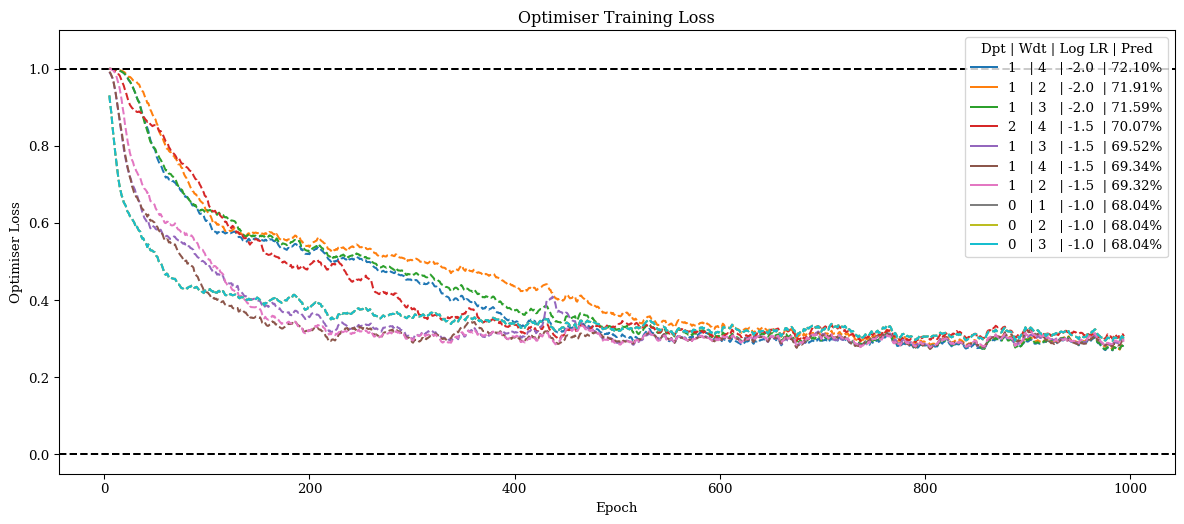

In [18]:
# Train
hyper_trainer, train_key = hyper_trainer.train_stochastic(
    # truth_prior, train_prior, epochs=500, batch_size=1000, key=train_key,
    # truth_prior, train_prior, epochs=1000, batch_size=250, key=jr.PRNGKey(0),
    truth_prior, train_prior, epochs=500, batch_size=25, truth_batch_size=25, key=train_key,
)
hyper_trainer.plot_losses(n_top=10, plot_losses=False)

  0%|          | 0/10 [00:00<?, ?it/s]

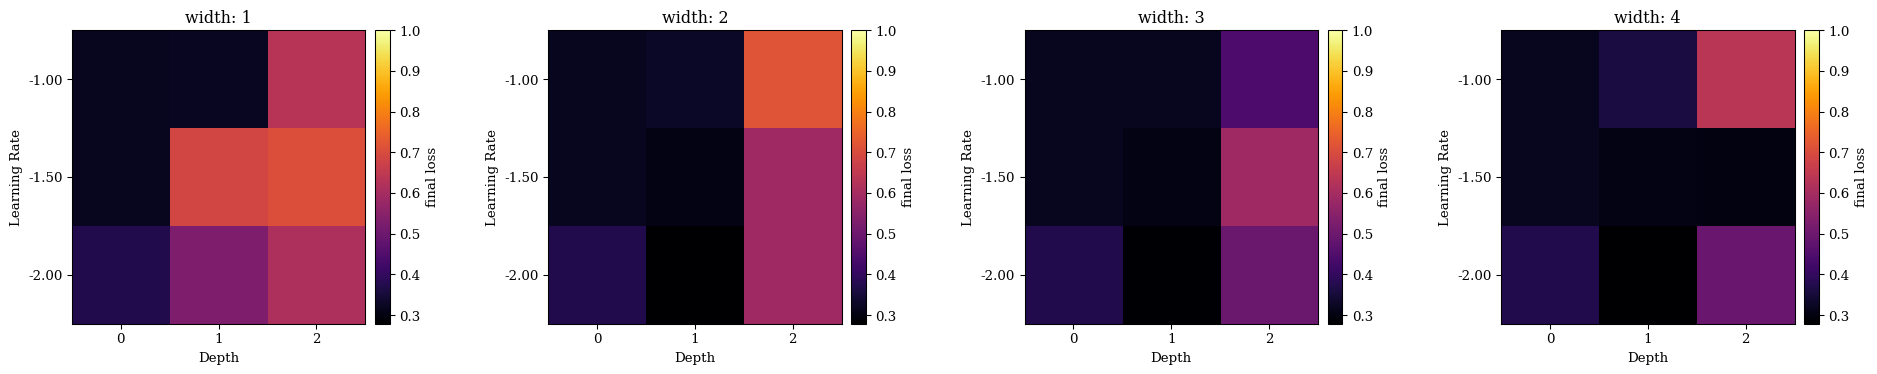

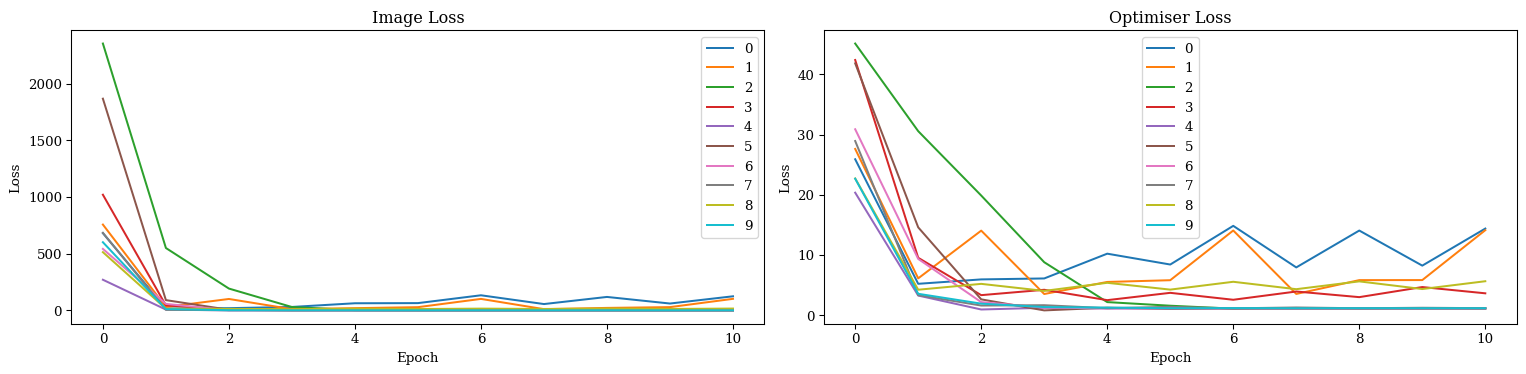

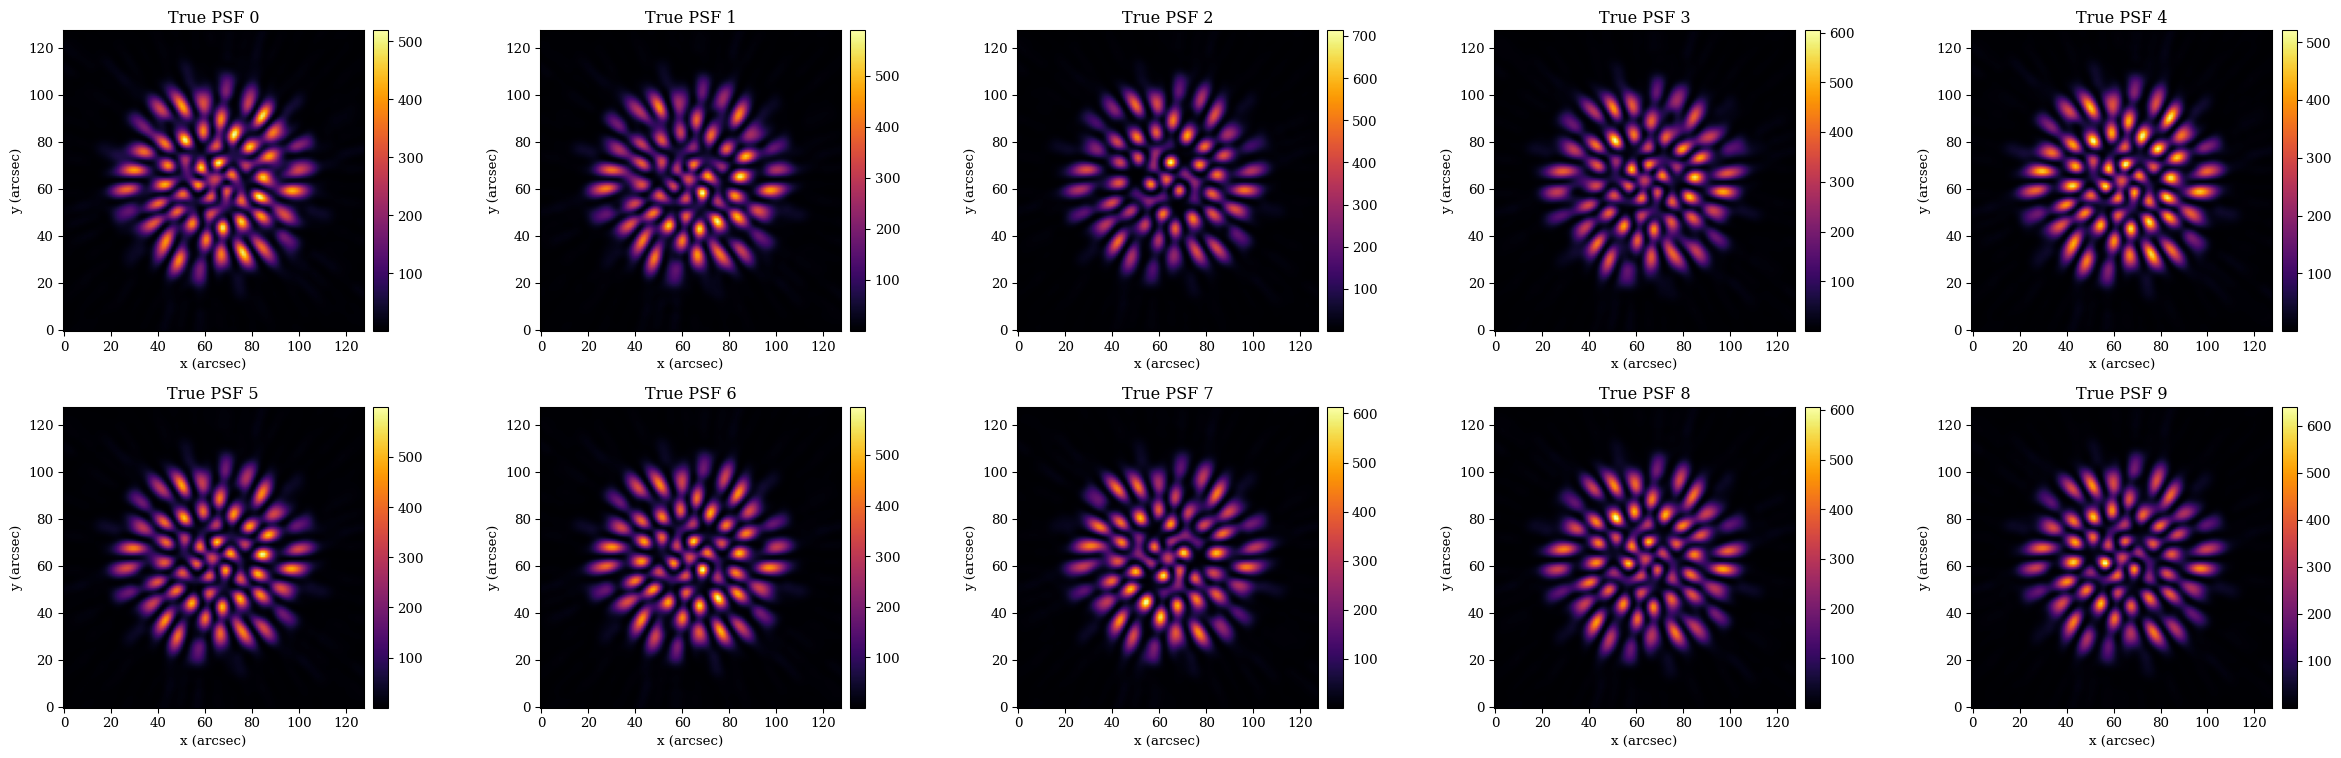

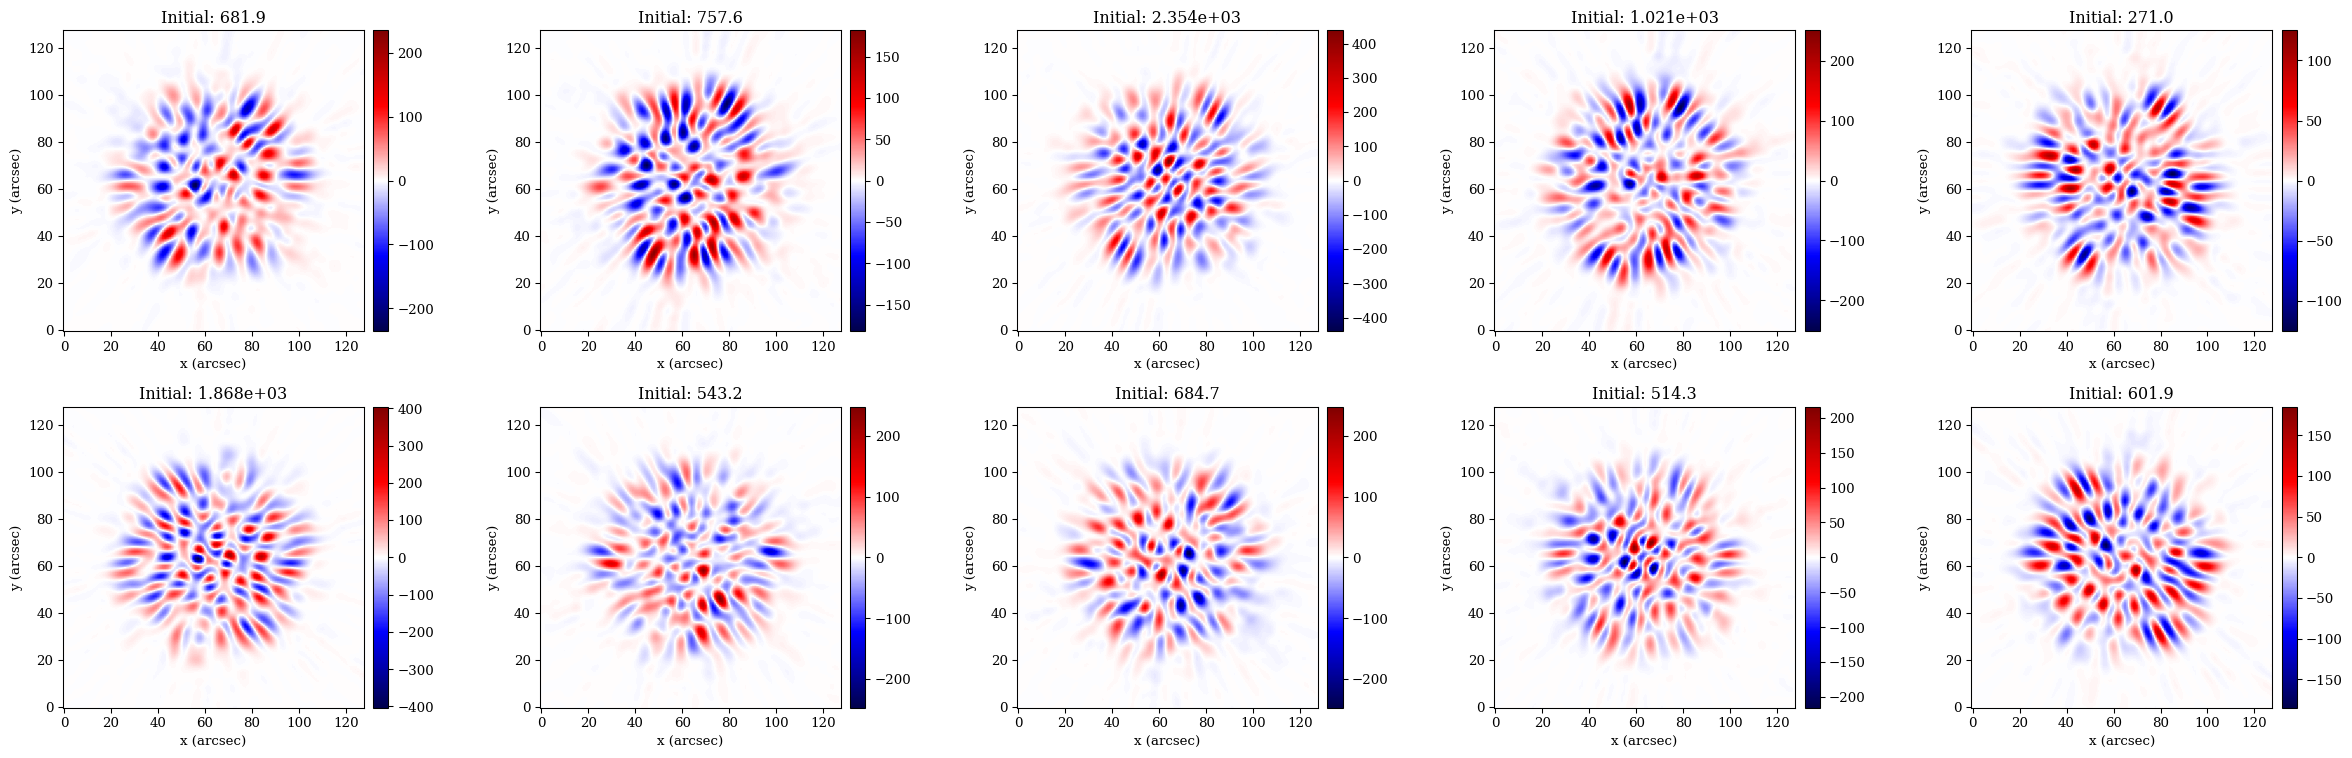

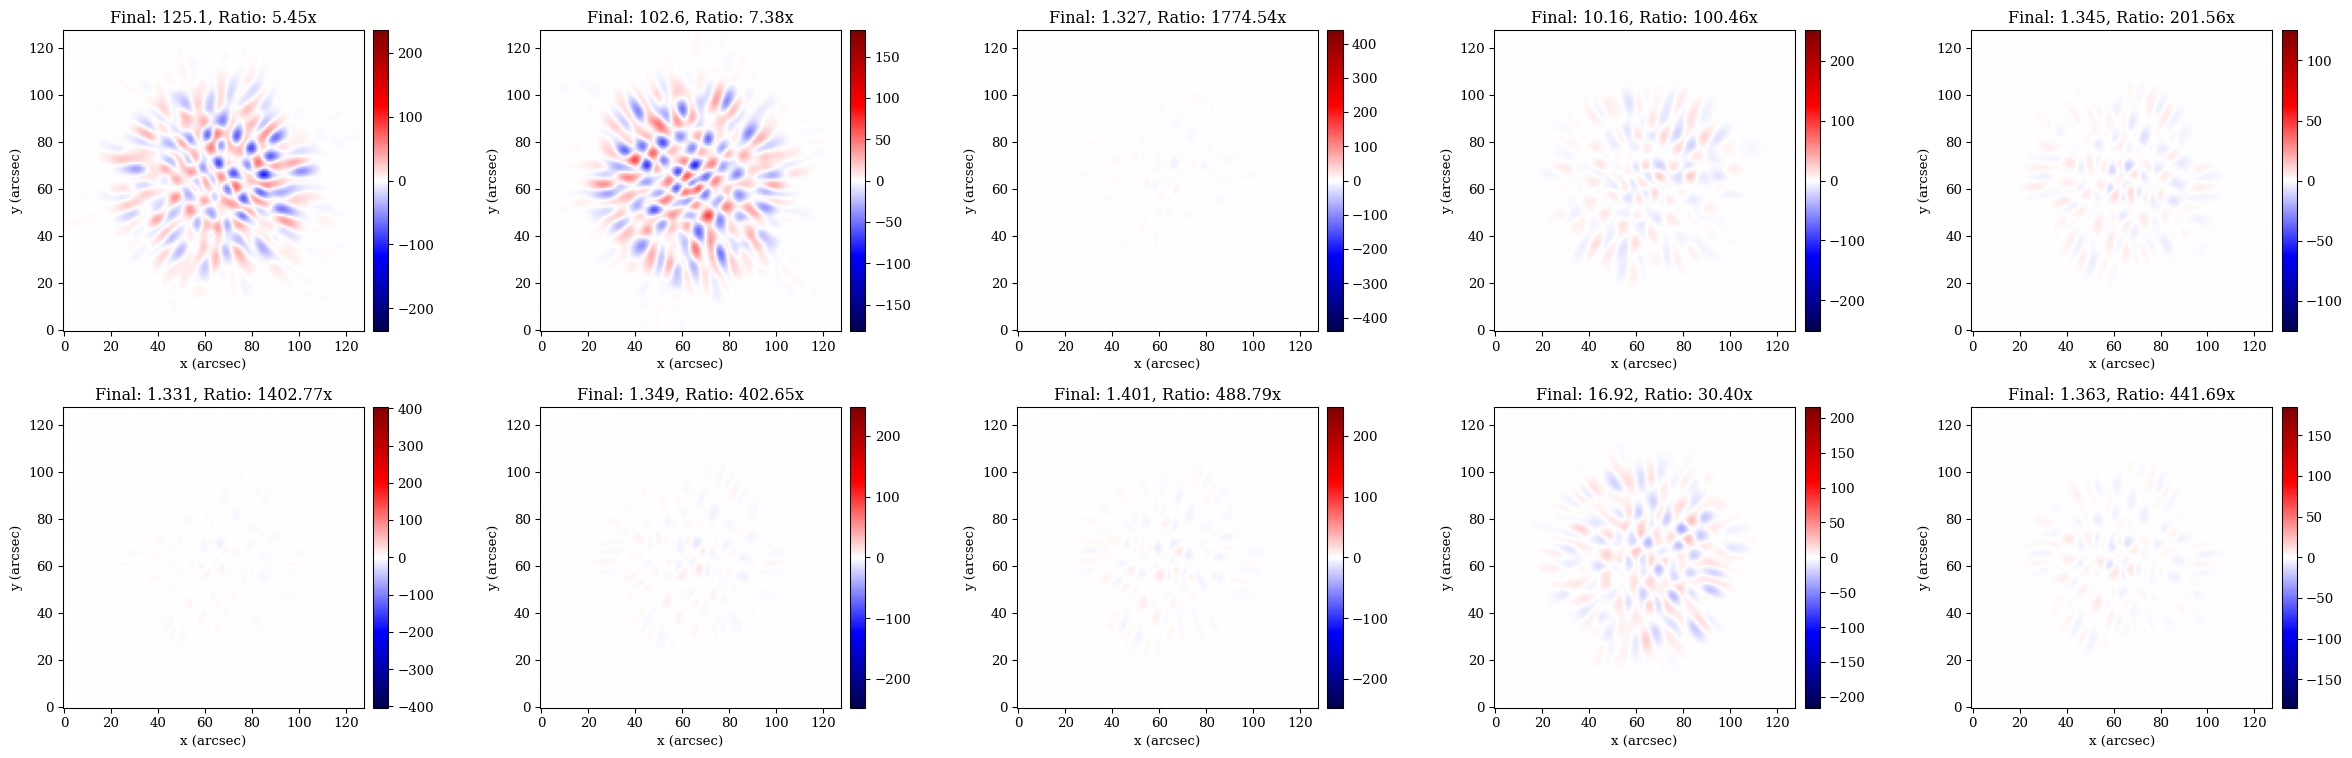

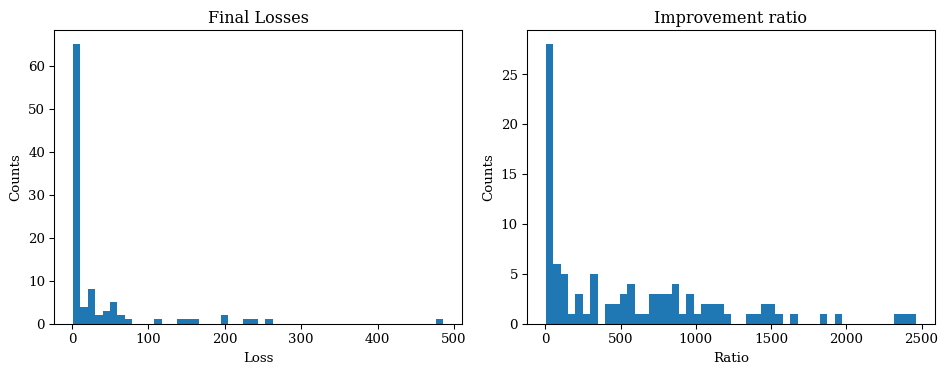

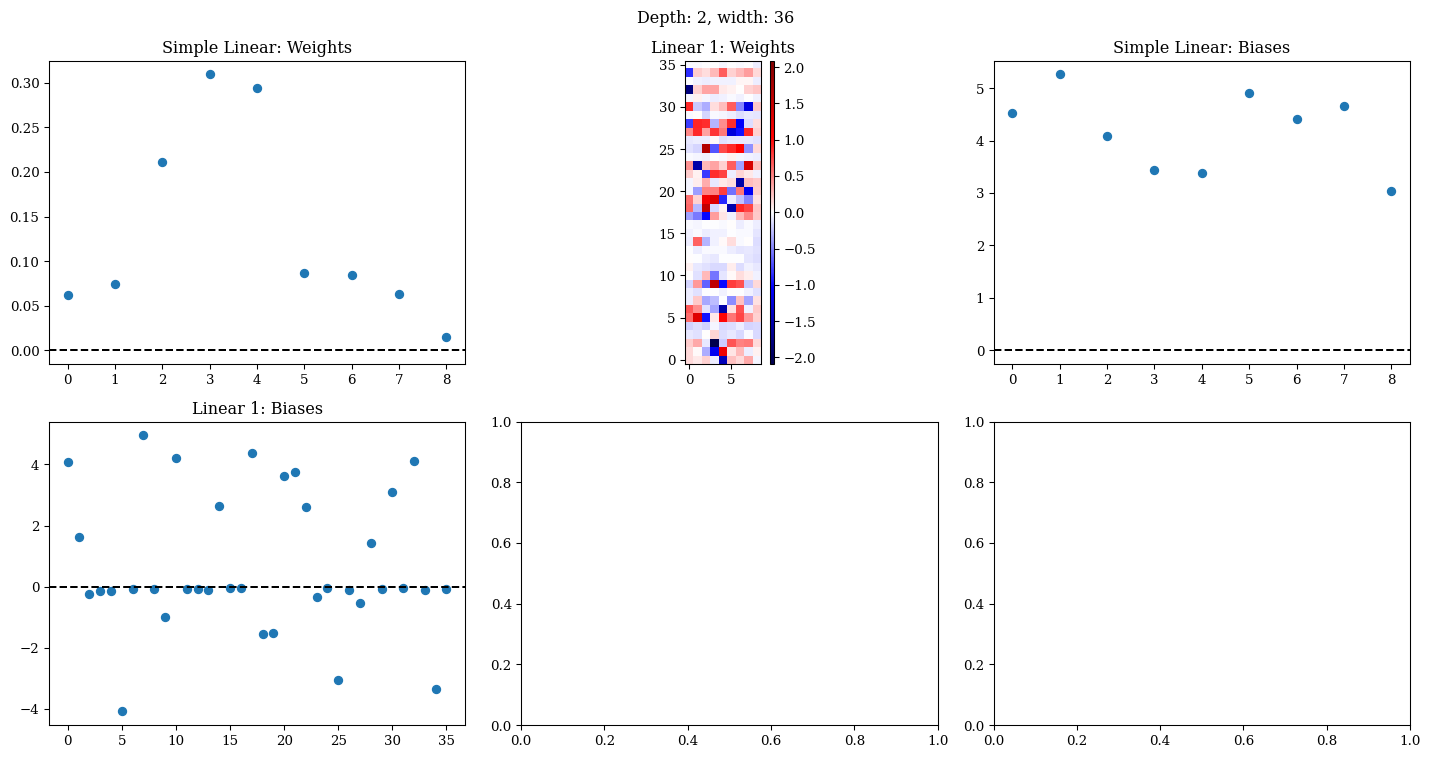

In [19]:
import numpy as onp

means = np.array(hyper_trainer.losses)[:, -1:].mean(1)
inds = np.argsort(means)
best = hyper_trainer.optimisers[inds[0]]
joint_model = eqx.tree_at(lambda tree: tree.optimiser, hyper_trainer.joint_model, best)


# Final loss vs hyper params
hypers_list = hyper_trainer.hypers
for mean, hyp in zip(means, hypers_list):
    hyp["loss"] = float(mean)
    hyp["lr"] = float(hyp["lr"])
    hyp["depth"] = int(hyp["depth"])
    hyp["width"] = int(hyp["width"])
dict_list = hypers_list

# Get a list of unique hyperparameter values
lr_values = sorted(set(d["lr"] for d in dict_list))
depth_values = sorted(set(d["depth"] for d in dict_list))
width_values = sorted(set(d["width"] for d in dict_list))

# Create a 3D array of losses for each combination of hyperparameters
loss_array = onp.zeros((len(lr_values), len(depth_values), len(width_values)))
for i, lr in enumerate(lr_values):
    for j, depth in enumerate(depth_values):
        for k, width in enumerate(width_values):
            for d in dict_list:
                if d["lr"] == lr and d["depth"] == depth and d["width"] == width:
                    loss_array[i, j, k] = d["loss"]


vmin = np.min(loss_array)
fig, axes = forge.plot_grid_2d(1, len(width_values))
for i in range(len(width_values)):
    im = axes[i].imshow(loss_array[:, :, i], vmin=vmin, vmax=1)
    forge.add_cbar(fig, axes[i], im, label="final loss")
    axes[i].set(
        title=f"width: {width_values[i]}",
        xlabel="Depth",
        ylabel="Learning Rate",
        xticks=range(len(depth_values)),
        yticks=range(len(lr_values)),
        xticklabels=depth_values,
        yticklabels=[f"{np.log10(lr):.2f}" for lr in lr_values],
    )
fig.tight_layout()

##################
### Optimising ###
##################


def optimise_fn(joint_model, sample, truth, data, n_opt=5):
    # Bind fns
    update = lambda x: joint_model.fmodel.set(joint_model.params, x)
    im_loss_fn = lambda x: joint_model.image_loss(update(x), data)
    dist_loss_fn = lambda x: np.linalg.norm(x - truth)

    # Optimise
    opt_losses, im_losses = [dist_loss_fn(sample)], [im_loss_fn(sample)]
    for i in range(n_opt):
        sample = joint_model.predict(sample, data)[0]
        fmodel = joint_model.fmodel.set(joint_model.params, sample)
        im_losses.append(im_loss_fn(sample))
        opt_losses.append(dist_loss_fn(sample))
    return np.array(opt_losses), np.array(im_losses), np.array(sample)


# TODO: Plot prediction loss too - 'training loss' and 'image loss'
rows, cols = 2, 5
n_opt = 10
n_samples = rows * cols
truths, key = forge.sample(truth_prior, n_samples, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

# Optimise
true_psfs = joint_model.model_samples(truths)
final_predictions = []
image_losses = []
optimiser_losses = []
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), true_psfs[j])
    data = true_psfs[j]
    opt_losses, im_losses, final_sample = optimise_fn(
        joint_model, samples[0][j], truths[0][j], data, n_opt
    )
    final_predictions.append(final_sample)
    image_losses.append(im_losses)
    optimiser_losses.append(opt_losses)

fig, axes = forge.plot_grid_2d(1, 2, fsx=8)
for i in range(n_samples):
    axes[0].plot(image_losses[i], label=i)
    axes[1].plot(optimiser_losses[i], label=i)
axes[0].set(xlabel="Epoch", ylabel="Loss", title=f"Image Loss")
axes[1].set(xlabel="Epoch", ylabel="Loss", title=f"Optimiser Loss")
axes[0].legend()
axes[1].legend()
fig.tight_layout()

##################
### Visualising ##
##################

# Get initial and predicted psfs
sample_psfs = joint_model.model_samples(samples)
predicted_psfs = joint_model.model_samples(np.array(final_predictions))

# Get residuals
initial_residuals = np.array(true_psfs) - np.array(sample_psfs)
final_residuals = np.array(true_psfs) - np.array(predicted_psfs)
residuals = np.array([initial_residuals, final_residuals])
vs = np.abs(residuals).max((0, -1, -2))

# Plot truth
fig, axes = forge.plot_grid_2d(rows, cols)
for i in range(n_samples):
    im = axes[i].imshow(true_psfs[i])
    axes[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"True PSF {i}",
    )
    forge.add_cbar(fig, axes[i], im)
fig.tight_layout()

# Plot Predicted
fig, axes = forge.plot_grid_2d(rows, cols)
for i in range(n_samples):
    im = axes[i].imshow(initial_residuals[i], vmin=-vs[i], vmax=vs[i], cmap="seismic")
    axes[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Initial: {image_losses[i][0]:.4}",
    )
    forge.add_cbar(fig, axes[i], im)
fig.tight_layout()

# Plot Final Residual
fig, axes = forge.plot_grid_2d(rows, cols)
for i in range(n_samples):
    improvement_ratio = image_losses[i][0] / image_losses[i][-1]
    im = axes[i].imshow(final_residuals[i], vmin=-vs[i], vmax=vs[i], cmap="seismic")
    axes[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Final: {image_losses[i][-1]:.4}, Ratio: {improvement_ratio:.2f}x",
    )
    forge.add_cbar(fig, axes[i], im)
fig.tight_layout()


# Histogram over a large sample
truths, key = forge.sample(truth_prior, 100, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, 100, key)
true_psfs = joint_model.model_samples(truths)
def opt_fn(sample, truth, data):
    opt_losses, im_losses, final_sample = optimise_fn(
        joint_model, sample, truth, data, n_opt=n_opt
    )
    return im_losses[-1], im_losses[0] / im_losses[-1]

final_loss, final_ratio = eqx.filter_vmap(opt_fn)(samples[0], truths[0], true_psfs)
fig, axes = forge.plot_grid_2d(1, 2)
axes[0].hist(final_loss, bins=50)
axes[0].set(title="Final Losses", xlabel="Loss", ylabel="Counts")
axes[1].hist(final_ratio, bins=50)
axes[1].set(title="Improvement ratio", xlabel="Ratio", ylabel="Counts")
fig.tight_layout()

# data = true_psfs[j]
# opt_losses, im_losses, final_sample = optimise_fn(
#     joint_model, samples[0][j], truths[0][j], data
# )
# final_predictions.append(final_sample)
# image_losses.append(im_losses)
# optimiser_losses.append(opt_losses)


# Examine predictions
forge.visualise_optimiser(joint_model.optimiser)

  0%|          | 0/100 [00:00<?, ?it/s]

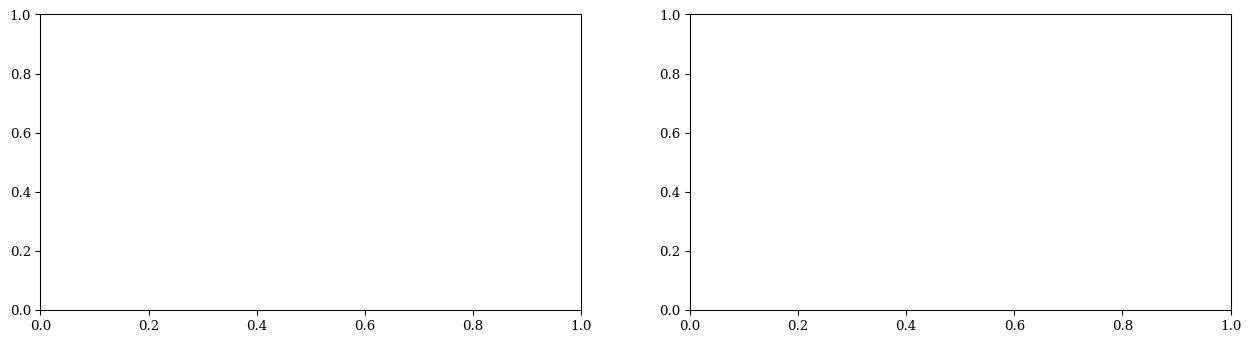

In [ ]:

# TODO: Plot prediction loss too - 'training loss' and 'image loss'
n_samples, n_opt = 100, 5
truths, key = forge.sample(truth_prior, n_samples, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

# fig, axes = forge.plot_grid_2d(n_samples//3, 3, fsx=8)
fig, axes = forge.plot_grid_2d(1, 2, fsx=8)
true_psfs = joint_model.model_samples(truths)
final_predictions = []
opt_losses = []
for j in tqdm(range(n_samples)):
    pred = samples[0][j]
    
    fmodel = joint_model.fmodel.set(joint_model.params, pred)
    dist_loss_fn = lambda x: np.linalg.norm(x - truths[0][j])
    im_losses = [joint_model.image_loss(fmodel, true_psfs[j])]
    opt_losses_ = [dist_loss_fn(pred)]
    for i in range(n_opt):
        pred = joint_model.predict(pred, true_psfs[j])
        
        # Get losses
        fmodel = joint_model.fmodel.set(joint_model.params, pred)
        im_losses.append(joint_model.image_loss(fmodel, true_psfs[j]))
        opt_losses_.append(dist_loss_fn(pred[0]))
    final_predictions.append(pred[0])
    opt_losses.append(opt_losses_)

In [ ]:
opt_losses.shape

(100, 11)

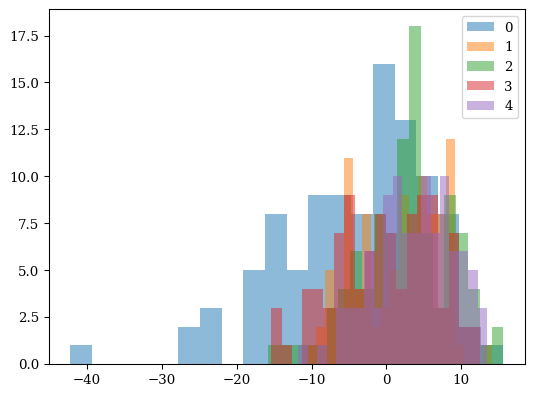

In [ ]:
opt_losses = np.array(opt_losses)

for i in range(n_opt):
    improvement = opt_losses[:, i+1] - opt_losses[:, i]
    plt.hist(improvement, label=i, alpha=0.5, bins=20)
plt.legend()
plt.show()

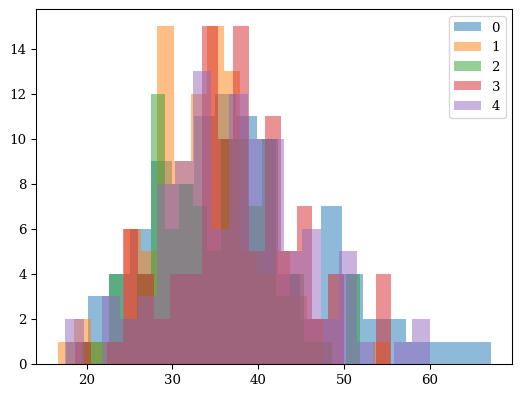

In [ ]:
opt_losses = np.array(opt_losses)

for i in range(n_opt):
    # improvement =  - opt_losses[:, i]
    plt.hist(opt_losses[:, i], label=i, alpha=0.5, bins=20)
plt.legend()
plt.show()

In [ ]:
np.array(truths).shape

(1, 100, 8)